In [1]:
import pathlib

import cartopy.crs as ccrs
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import easygems.healpix as egh
from easygems import remap


datapath = pathlib.Path("/pool/data/ICDC/atmosphere/imerg/DATA/")
ds = xr.open_mfdataset(datapath.glob("2021/IMERG_precipitationrate__V06B__halfhourly__0.1degree__202101*.nc"))
ds = ds.stack(xy=("lon", "lat"))  # flatten the source grid

zoom = 6
hp_lon, hp_lat = hp.pix2ang(
    nside=hp.order2nside(zoom),
    ipix=np.arange(hp.order2npix(zoom)), 
    lonlat=True,
    nest=True,
)

In [2]:
%%time
# This is the heavy computation (similar to -gen* in CDO)
weights = remap.compute_weights_delaunay((ds.lon % 360, ds.lat), (hp_lon, hp_lat))

# but we could store the computed weights
# weights.to_netcdf("imerge_healpix_weights.nc")

CPU times: user 2min 17s, sys: 32.3 s, total: 2min 49s
Wall time: 2min 11s


In [3]:
ds_remap = xr.apply_ufunc(
    remap.apply_weights,
    ds,
    kwargs=weights,
    input_core_dims=[["xy"]],
    output_core_dims=[["cell"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"cell": hp.order2npix(zoom)},
    },
)

CPU times: user 2.46 s, sys: 1min, total: 1min 3s
Wall time: 1min 13s


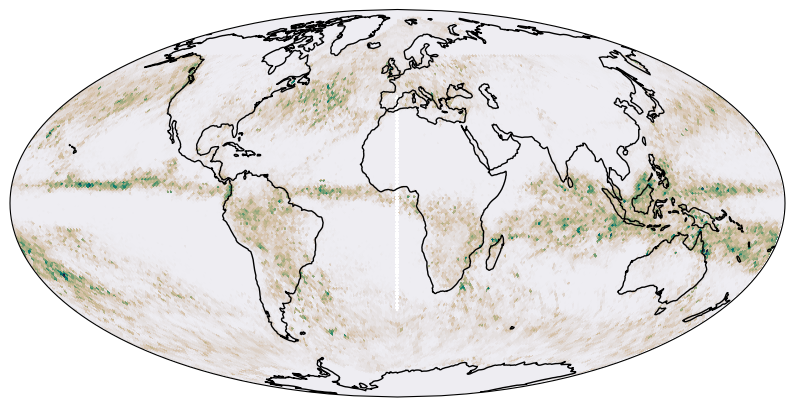

In [4]:
%%time
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.Mollweide()})
ax.coastlines()
ax.set_global()
egh.healpix_show(
    ds_remap.calibrated_precipitation.sel(time=slice("2021-01-01", "2021-01-31", 24)).mean("time"),
    vmin=0,
    cmap="cmo.rain",
)